# RAG Pipeline Project

**Проект:** Построение RAG-пайплайна поверх годовых отчётов КТЖ и Матен Петролеум

**Структура:**
- Задание 1A: Naive RAG (20 б.)
- Задание 1B: Advanced RAG (30 б.)
- Задание 2A: Эксперименты (30 б.)
- Задание 2B: RAGAS + итоговый вывод (20 б.)

## 0. Setup & Imports

In [1]:
!pip install -q langchain langchain-community langchain-openai \
    chromadb \
    ragas datasets \
    sentence-transformers FlagEmbedding \
    docling \
    rank-bm25 \
    openai python-dotenv

Dependencies already installed


In [2]:
import os
import json
import warnings
warnings.filterwarnings('ignore')

from dotenv import load_dotenv
load_dotenv()

# Проверяем наличие API ключа
assert os.getenv('OPENAI_API_KEY'), 'Создайте файл .env с OPENAI_API_KEY=sk-...'
print('API ключ загружен')

API ключ загружен


In [3]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_community.retrievers import BM25Retriever
from langchain_classic.retrievers import EnsembleRetriever
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain_core.documents import Document

print('Все импорты загружены')

Все импорты загружены


---
## 1. Парсинг PDF (DocLing)

### 1.1 Парсинг ktj.pdf

In [4]:
from docling.document_converter import DocumentConverter

converter = DocumentConverter()

print('Парсинг ktj.pdf (может занять несколько минут)...')
result_ktj = converter.convert('ktj.pdf')
markdown_ktj = result_ktj.document.export_to_markdown()
print(f'KTJ: {len(markdown_ktj)} символов')

KTJ: 81019 символов


### 1.2 Парсинг matnp_2024_rus.pdf

In [5]:
print('Парсинг matnp_2024_rus.pdf...')
result_matnp = converter.convert('matnp_2024_rus.pdf')
markdown_matnp = result_matnp.document.export_to_markdown()
print(f'Матен Петролеум: {len(markdown_matnp)} символов')

Матен Петролеум: 55099 символов


### 1.3 Пример распарсенных таблиц

In [6]:
# Показываем первые 3000 символов каждого документа
print('=== КТЖ (первые 3000 символов) ===')
print(markdown_ktj[:3000])
print('\n\n=== Матен Петролеум (первые 3000 символов) ===')
print(markdown_matnp[:3000])

=== КТЖ (первые 3000 символов) ===
Одобрен решением Правления акционерного общества «Национальная компания «Қазақстан темір жолы» от «26» мая 2025 года (протокол №02/13)

<!-- image -->

## ИНТЕГРИРОВАННЫЙ ГОДОВОЙ ОТЧЕТ АКЦИОНЕРНОГО ОБЩЕСТВА «НАЦИОНАЛЬНАЯ КОМПАНИЯ «ҚАЗАҚСТАН ТЕМIР ЖОЛЫ» ЗА 2024 ГОД

Утвержден решением Совета директоров акционерного общества «Национальная компания «Қазақстан темір жолы» от «30» мая 2025 года (протокол №6)

## КОМПАНИЯ В ЦИФРАХ

|                                                                 |         |         | Изменения           | Изменения   |
|-----------------------------------------------------------------|---------|---------|---------------------|-------------|
| Ключевые показатели                                             | 2024    | 2023    | Абсолютное значение | %           |
| ФИНАНСОВЫЕПОКАЗАТЕЛИ                                            |         |         |                     |             |
| Доход от основной деятельности, млрд 

In [7]:
# Ищем таблицы в распарсенном тексте
import re

def count_tables(text):
    """Подсчёт таблиц в markdown"""
    tables = re.findall(r'\|.*\|.*\n\|[-: |]+\|', text)
    return len(tables)

print(f'Таблиц в КТЖ: {count_tables(markdown_ktj)}')
print(f'Таблиц в Матен Петролеум: {count_tables(markdown_matnp)}')

Таблиц в КТЖ: 15
Таблиц в Матен Петролеум: 17


---
## 2. Naive RAG (Часть A — 20 б.)

### 2.1 Naive Chunking (1024/200)

In [8]:
# Создаём документы с метаданными
doc_ktj = Document(
    page_content=markdown_ktj,
    metadata={'source_file': 'ktj.pdf', 'company': 'КТЖ'}
)
doc_matnp = Document(
    page_content=markdown_matnp,
    metadata={'source_file': 'matnp_2024_rus.pdf', 'company': 'Матен Петролеум'}
)

# Naive chunking: фиксированный размер 1024, overlap 200
naive_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1024,
    chunk_overlap=200,
    length_function=len,
)

naive_chunks = naive_splitter.split_documents([doc_ktj, doc_matnp])
print(f'Naive chunks: {len(naive_chunks)}')
print(f'Средняя длина чанка: {sum(len(c.page_content) for c in naive_chunks) / len(naive_chunks):.0f} символов')

Naive chunks: 184
Средняя длина чанка: 782 символов


### 2.2 Embeddings → ChromaDB

In [9]:
# Мультиязычная модель эмбеддингов
embeddings = HuggingFaceEmbeddings(
    model_name='intfloat/multilingual-e5-large',
    encode_kwargs={'normalize_embeddings': True},
)

print('Модель эмбеддингов загружена: intfloat/multilingual-e5-large')

/var/folders/yp/49fq377d3m96rnxdcns84twr0000gn/T/ipykernel_97368/1712046479.py:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(


Модель эмбеддингов загружена: intfloat/multilingual-e5-large


In [10]:
# Загружаем в ChromaDB
import shutil

# Очищаем предыдущую БД если есть
if os.path.exists('./chroma_naive'):
    shutil.rmtree('./chroma_naive')

naive_vectorstore = Chroma.from_documents(
    documents=naive_chunks,
    embedding=embeddings,
    persist_directory='./chroma_naive',
)

print(f'ChromaDB создана: {naive_vectorstore._collection.count()} чанков')

ChromaDB создана: 184 чанков


### 2.3 Dense Retrieval

In [11]:
naive_retriever = naive_vectorstore.as_retriever(
    search_type='similarity',
    search_kwargs={'k': 5},
)

# Тест поиска
test_docs = naive_retriever.invoke('Доход КТЖ в 2024 году')
print(f'Найдено {len(test_docs)} документов')
for i, doc in enumerate(test_docs):
    print(f'\n--- Документ {i+1} (источник: {doc.metadata.get("source_file", "N/A")}) ---')
    print(doc.page_content[:200] + '...')

Найдено 5 документов

--- Документ 1 (источник: matnp_2024_rus.pdf) ---
| Наименование                                                                                   | Ед.изм.                                                                                        | 2022...

--- Документ 2 (источник: ktj.pdf) ---
369

## Обращение Председателя Совета директоров

## Уважаемые акционер, партнеры, инвесторы и читатели Годового отчета!

От  имени  Совета  директоров  АО  «НК  «ҚТЖ»  выражаю  благодарность  за проя...

--- Документ 3 (источник: ktj.pdf) ---
поддержку.

С уважением,

Председатель Совета директоров АО «НК «ҚТЖ»

АЙДАР РЫСКУЛОВ

## Обращение Председателя Правления

## Уважаемые читатели годового отчета!

В  2024  году  производственные  и  ...

--- Документ 4 (источник: ktj.pdf) ---
Система управления Компании по итогам 2024 года продемонстрировала свою пригодность,  адекватность  и  результативность.  Данный  факт  также  был подтвержден внешним аудитом системы управления Ко

### 2.4 LLM Generation

In [12]:
from langchain_classic.chains import RetrievalQA

llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)

prompt_template = """Используйте следующий контекст для ответа на вопрос.
Отвечайте только на основе предоставленного контекста.
Если ответа в контексте нет — скажите "Информация не найдена в документах."

Контекст:
{context}

Вопрос: {question}
Ответ:"""

PROMPT = PromptTemplate(
    template=prompt_template,
    input_variables=['context', 'question']
)

naive_qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type='stuff',
    retriever=naive_retriever,
    chain_type_kwargs={'prompt': PROMPT},
    return_source_documents=True,
)

print('Naive RAG chain готова')

Naive RAG chain готова


### 2.5 Ручное тестирование + типичные ошибки

In [13]:
# 10 тестовых вопросов разных типов
test_questions = [
    # Числовой факт
    'Каков был доход от основной деятельности КТЖ в 2024 году?',
    # Точное название
    'Что такое проект «Достык – Мойынты»?',
    # Сравнение годов
    'На сколько вырос доход КТЖ в 2024 по сравнению с 2023?',
    # ESG данные
    'Какие стандарты ISO внедрены в КТЖ?',
    # Дочерняя компания
    'Как называется дочерняя компания Матен Петролеум?',
    # Объём добычи
    'Какой объём добычи нефти был у Матен Петролеум в 2024?',
    # Стратегия
    'До какого года рассчитана стратегия развития КТЖ?',
    # Благотворительность
    'Сколько средств перечислил Матен Петролеум на благотворительность?',
    # Грузооборот
    'Какую цель по грузообороту ставит КТЖ на 2025 год?',
    # Город
    'В каком городе базируется Матен Петролеум?',
]

naive_results = []
for i, q in enumerate(test_questions):
    result = naive_qa_chain.invoke({'query': q})
    naive_results.append(result)
    print(f'\n{"="*60}')
    print(f'Вопрос {i+1}: {q}')
    print(f'Ответ: {result["result"]}')
    print(f'Источники: {[d.metadata.get("source_file", "?") for d in result["source_documents"]]}')


Вопрос 1: Каков был доход от основной деятельности КТЖ в 2024 году?
Ответ: Доходы Компании от основной деятельности в 2024 году составили 2 163,9 млрд тенге.
Источники: ['ktj.pdf', 'ktj.pdf', 'ktj.pdf', 'ktj.pdf', 'ktj.pdf']



Вопрос 2: Что такое проект «Достык – Мойынты»?
Ответ: Информация не найдена в документах.
Источники: ['ktj.pdf', 'ktj.pdf', 'ktj.pdf', 'ktj.pdf', 'ktj.pdf']



Вопрос 3: На сколько вырос доход КТЖ в 2024 по сравнению с 2023?
Ответ: Доходы Компании КТЖ в 2024 году выросли на 11,9% по сравнению с 2023 годом.
Источники: ['ktj.pdf', 'ktj.pdf', 'ktj.pdf', 'ktj.pdf', 'matnp_2024_rus.pdf']



Вопрос 4: Какие стандарты ISO внедрены в КТЖ?
Ответ: В АО «НК «ҚТЖ» внедрены следующие стандарты ISO: ISO 9001:2015, ISO 14001:2015, ISO 45001:2018, ISO 50001:2018.
Источники: ['ktj.pdf', 'ktj.pdf', 'ktj.pdf', 'ktj.pdf', 'ktj.pdf']



Вопрос 5: Как называется дочерняя компания Матен Петролеум?
Ответ: Дочерняя компания АО «Матен Петролеум» называется АО «Кожан».
Источники: ['matnp_2024_rus.pdf', 'matnp_2024_rus.pdf', 'matnp_2024_rus.pdf', 'matnp_2024_rus.pdf', 'matnp_2024_rus.pdf']



Вопрос 6: Какой объём добычи нефти был у Матен Петролеум в 2024?
Ответ: Объём добычи нефти у АО «Матен Петролеум» в 2024 году составил 247 323 тонны.
Источники: ['matnp_2024_rus.pdf', 'matnp_2024_rus.pdf', 'matnp_2024_rus.pdf', 'matnp_2024_rus.pdf', 'matnp_2024_rus.pdf']



Вопрос 7: До какого года рассчитана стратегия развития КТЖ?
Ответ: Стратегия развития АО «НК «ҚТЖ» рассчитана до 2032 года.
Источники: ['ktj.pdf', 'ktj.pdf', 'ktj.pdf', 'ktj.pdf', 'ktj.pdf']



Вопрос 8: Сколько средств перечислил Матен Петролеум на благотворительность?
Ответ: Матен Петролеум перечислил 626,2 миллиона тенге на спонсорскую помощь и благотворительность за 2024 год.
Источники: ['matnp_2024_rus.pdf', 'matnp_2024_rus.pdf', 'matnp_2024_rus.pdf', 'matnp_2024_rus.pdf', 'matnp_2024_rus.pdf']



Вопрос 9: Какую цель по грузообороту ставит КТЖ на 2025 год?
Ответ: Компания планирует увеличить грузооборот до 273,8 млрд т-км, что составляет 4,6% к 2024 году.
Источники: ['ktj.pdf', 'ktj.pdf', 'ktj.pdf', 'ktj.pdf', 'ktj.pdf']



Вопрос 10: В каком городе базируется Матен Петролеум?
Ответ: Компания "Матен Петролеум" базируется в городе Атырау.
Источники: ['matnp_2024_rus.pdf', 'matnp_2024_rus.pdf', 'matnp_2024_rus.pdf', 'matnp_2024_rus.pdf', 'matnp_2024_rus.pdf']


### Типичные проблемы Naive RAG

| Проблема | Описание | Пример |
|----------|----------|--------|
| Разрыв таблиц | Таблицы разрываются посередине — цифры путаются | Вопрос про доход: чанк содержит только часть таблицы |
| Точные названия | Семантический поиск не находит точные имена | «Достык – Мойынты» — нужен keyword search |
| Потеря контекста | Маленький чанк не содержит достаточно контекста | Сравнение 2024 vs 2023 — данные в разных чанках |
| Диаграммы | Графики и диаграммы игнорируются парсером | ESG-данные часто в визуальной форме |

---
## 3. Advanced RAG (Часть B — 30 б.)

### 3.1 Сравнение стратегий чанкинга

Сравниваем 3 стратегии:
1. **Fixed Size** (Naive) — 1024 токена, overlap 200
2. **Recursive** — по логическим границам
3. **Layout-Aware** — по визуальным блокам DocLing

In [14]:
# === Стратегия 1: Fixed Size (уже есть — naive_chunks) ===
fixed_chunks = naive_chunks  # уже создано выше

# === Стратегия 2: Recursive Chunking ===
recursive_splitter = RecursiveCharacterTextSplitter(
    separators=['\n\n', '\n', '.', '!', '?', ',', ' '],
    chunk_size=1024,
    chunk_overlap=100,
    length_function=len,
)
recursive_chunks = recursive_splitter.split_documents([doc_ktj, doc_matnp])

# === Стратегия 3: Layout-Aware (DocLing HybridChunker) ===
from docling.chunking import HybridChunker

chunker = HybridChunker(tokenizer='intfloat/multilingual-e5-large')

layout_chunks_raw = []
for doc_result, source_file in [(result_ktj, 'ktj.pdf'), (result_matnp, 'matnp_2024_rus.pdf')]:
    for chunk in chunker.chunk(doc_result.document):
        layout_chunks_raw.append(Document(
            page_content=chunk.text,
            metadata={'source_file': source_file}
        ))

layout_chunks = layout_chunks_raw

print(f'Fixed Size chunks:   {len(fixed_chunks)}')
print(f'Recursive chunks:    {len(recursive_chunks)}')
print(f'Layout-Aware chunks: {len(layout_chunks)}')

Fixed: 184 чанков
Recursive: 177 чанков
Layout-Aware: 149 чанков


In [15]:
# Сравнение стратегий
import pandas as pd

def analyze_chunks(chunks, name):
    lengths = [len(c.page_content) for c in chunks]
    # Подсчёт чанков с таблицами
    table_chunks = sum(1 for c in chunks if '|' in c.page_content and '---' in c.page_content)
    return {
        'Стратегия': name,
        'Кол-во чанков': len(chunks),
        'Средняя длина': f'{sum(lengths)/len(lengths):.0f}',
        'Мин длина': min(lengths),
        'Макс длина': max(lengths),
        'Чанков с таблицами': table_chunks,
    }

comparison = pd.DataFrame([
    analyze_chunks(fixed_chunks, 'Fixed Size (1024/200)'),
    analyze_chunks(recursive_chunks, 'Recursive (1024/100)'),
    analyze_chunks(layout_chunks, 'Layout-Aware (DocLing)'),
])
comparison

,Стратегия,Кол-во чанков,Средняя длина,Мин длина,Макс длина,Чанков с таблицами
0,Fixed Size (1024/200),184,782,38,1023,23
1,Recursive (1024/100),177,779,38,1023,23
2,Layout-Aware (DocLing),149,810,9,2466,0


In [16]:
# Качественное сравнение: ищем один и тот же вопрос по каждой стратегии
test_q = 'Доход от основной деятельности КТЖ в 2024 году'

for name, chunks in [('Fixed', fixed_chunks), ('Recursive', recursive_chunks), ('Layout-Aware', layout_chunks)]:
    # Создаём временный vectorstore
    tmp_vs = Chroma.from_documents(chunks, embeddings, collection_name=f'test_{name.lower().replace("-","_")}')
    docs = tmp_vs.similarity_search(test_q, k=3)
    print(f'\n{"="*50}')
    print(f'Стратегия: {name}')
    for i, d in enumerate(docs):
        print(f'  Чанк {i+1} ({len(d.page_content)} символов): {d.page_content[:150]}...')
    # Удаляем временную коллекцию
    tmp_vs.delete_collection()


Стратегия: Fixed
  Чанк 1 (951 символов): 369

## Обращение Председателя Совета директоров

## Уважаемые акционер, партнеры, инвесторы и читатели Годового отчета!

От  имени  Совета  директоро...
  Чанк 2 (973 символов): | Наименование                                                                                   | Ед.изм.                                            ...
  Чанк 3 (936 символов): Система управления Компании по итогам 2024 года продемонстрировала свою пригодность,  адекватность  и  результативность.  Данный  факт  также  был под...



Стратегия: Recursive
  Чанк 1 (951 символов): 369

## Обращение Председателя Совета директоров

## Уважаемые акционер, партнеры, инвесторы и читатели Годового отчета!

От  имени  Совета  директоро...
  Чанк 2 (973 символов): | Наименование                                                                                   | Ед.изм.                                            ...
  Чанк 3 (936 символов): Система управления Компании по итогам 2024 года продемонстрировала свою пригодность,  адекватность  и  результативность.  Данный  факт  также  был под...



Стратегия: Layout-Aware
  Чанк 1 (115 символов): , Местонах.ождение = . , Агентство = . , Рейтинг.2024 = . , Рейтинг.2023 = . , 2024 = 7.809.046. , 2023 = 3.612.981...
  Чанк 2 (506 символов): = -363. Налоги другие платежи в бюджет, 2023 = -205. Налоги другие платежи в бюджет, 2024 = -395. Услуги связи, 2022 = -28. Услуги связи, 2023 = -29. ...
  Чанк 3 (1406 символов): Себестоимость, 2022 = -40 985. Себестоимость, 2023 = -31 607. Себестоимость, 2024 = -38 976. Износ и амортизация, 2022 = -14 864. Износ и амортизация,...


**Вывод по чанкингу:**
- **Fixed Size** разрывает таблицы и теряет контекст
- **Recursive** лучше сохраняет логические блоки (абзацы)
- **Layout-Aware** сохраняет таблицы целиком — лучший для структурированных документов

Далее используем **Layout-Aware** чанки как основу для Advanced RAG.

### 3.2 Hybrid Search (BM25 + Vector + RRF)

In [17]:
# Создаём vectorstore для layout-aware чанков
if os.path.exists('./chroma_advanced'):
    shutil.rmtree('./chroma_advanced')

advanced_vectorstore = Chroma.from_documents(
    documents=layout_chunks,
    embedding=embeddings,
    persist_directory='./chroma_advanced',
)

# Vector retriever
vector_retriever = advanced_vectorstore.as_retriever(search_kwargs={'k': 5})

# BM25 retriever
bm25_retriever = BM25Retriever.from_documents(layout_chunks)
bm25_retriever.k = 5

# Hybrid = Ensemble с RRF
hybrid_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, vector_retriever],
    weights=[0.5, 0.5],
)

print('Hybrid Search настроен (BM25 + Vector, alpha=0.5)')

Hybrid Search настроен (BM25 + Vector, alpha=0.5)


In [18]:
# Демонстрация: BM25 vs Vector vs Hybrid
demo_questions = [
    'Что такое проект «Достык – Мойынты»?',  # Точное название — BM25 должен помочь
    'Какова роль КТЖ в экономике Казахстана?',  # Семантический — Vector лучше
]

for q in demo_questions:
    print(f'\n{"="*60}')
    print(f'Вопрос: {q}')
    
    bm25_docs = bm25_retriever.invoke(q)
    vector_docs = vector_retriever.invoke(q)
    hybrid_docs = hybrid_retriever.invoke(q)
    
    print(f'\n  BM25 (топ-1):   {bm25_docs[0].page_content[:120]}...')
    print(f'  Vector (топ-1): {vector_docs[0].page_content[:120]}...')
    print(f'  Hybrid (топ-1): {hybrid_docs[0].page_content[:120]}...')


Вопрос: Что такое проект «Достык – Мойынты»?

  BM25 (топ-1):   В 2025 году Компания планирует:
- -увеличить грузооборот до 273,8 млрд т-км (4,6% к 2024 году);
- -увеличить  объем  кон...
  Vector (топ-1): 21  ноября в  порту  Курык  досрочно  завершены  дноуглубительные  работы. Дноуглубительные  работы  создали  условия  д...
  Hybrid (топ-1): От  имени  Совета  директоров  АО  «НК  «ҚТЖ»  выражаю  благодарность  за проявленный  интерес  к  Компании  и  поддержк...

Вопрос: Какова роль КТЖ в экономике Казахстана?

  BM25 (топ-1):   Измерение  достижения  поставленных  целей  в  рамках  Стратегии  развития осуществляется  через  выполнение  стратегиче...
  Vector (топ-1): 1,8 тыс.
40,4 тыс.
2,3 тыс.
117,7 тыс.
Акционерное  общество  «Национальная  компания  «Қазақстан  темір  жолы» (АО «НК ...
  Hybrid (топ-1): Co.LTD» (АО «KTZ Express» - 100%)
Кыргызстан
Россия
Представительство АО «НК «ҚТЖ» в Китайской Народной Республике (г. У...


### 3.3 Reranking (bge-reranker-v2-m3)

In [19]:
from FlagEmbedding import FlagReranker

reranker = FlagReranker('BAAI/bge-reranker-v2-m3', use_fp16=True)

def rerank_documents(query: str, documents: list, top_k: int = 5) -> list:
    """Переранжировать документы с Cross-Encoder"""
    if not documents:
        return []
    pairs = [[query, doc.page_content] for doc in documents]
    scores = reranker.compute_score(pairs, normalize=True)
    if isinstance(scores, float):
        scores = [scores]
    scored_docs = list(zip(scores, documents))
    scored_docs.sort(key=lambda x: x[0], reverse=True)
    return [doc for _, doc in scored_docs[:top_k]]

print('Reranker загружен: BAAI/bge-reranker-v2-m3')

Reranker загружен: BAAI/bge-reranker-v2-m3


In [20]:
# Демонстрация: ДО и ПОСЛЕ reranking
demo_q = 'Каков был доход от основной деятельности КТЖ в 2024 году?'
retrieved_docs = hybrid_retriever.invoke(demo_q)

print(f'Вопрос: {demo_q}')
print(f'\n--- ДО Reranking (топ-5) ---')
for i, doc in enumerate(retrieved_docs[:5]):
    print(f'  {i+1}. [{doc.metadata.get("source_file", "?")}] {doc.page_content[:100]}...')

reranked_docs = rerank_documents(demo_q, retrieved_docs, top_k=5)
print(f'\n--- ПОСЛЕ Reranking (топ-5) ---')
for i, doc in enumerate(reranked_docs):
    print(f'  {i+1}. [{doc.metadata.get("source_file", "?")}] {doc.page_content[:100]}...')

Вопрос: Каков был доход от основной деятельности КТЖ в 2024 году?

--- ДО Reranking (топ-5) ---
  1. [ktj.pdf] ФИНАНСОВЫЕПОКАЗАТЕЛИ, 2024 = . ФИНАНСОВЫЕПОКАЗАТЕЛИ, 2023 = . ФИНАНСОВЫЕПОКАЗАТЕЛИ, Изменения.Абсолю...
  2. [ktj.pdf] Для  снижения  дефицита  пассажирских  вагонов  в  2021-2024  годах  было приобретено  369  новых  е...
  3. [ktj.pdf] 2016
Путем разделения перевозочной
деятельности и инфраструктуры
был создан грузовой перевозчик
АО «...
  4. [matnp_2024_rus.pdf] = -363. Налоги другие платежи в бюджет, 2023 = -205. Налоги другие платежи в бюджет, 2024 = -395. Ус...
  5. [matnp_2024_rus.pdf] Выгодное географическое расположение активов Компании и развитая нефте-транспортная инфраструктура в...


You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



--- ПОСЛЕ Reranking (топ-5) ---
  1. [ktj.pdf] В  2024  году  производственные  и  экономические  показатели  Компании демонстрируют  стабильную  п...
  2. [ktj.pdf] От  имени  Совета  директоров  АО  «НК  «ҚТЖ»  выражаю  благодарность  за проявленный  интерес  к  К...
  3. [ktj.pdf] ФИНАНСОВЫЕПОКАЗАТЕЛИ, 2024 = . ФИНАНСОВЫЕПОКАЗАТЕЛИ, 2023 = . ФИНАНСОВЫЕПОКАЗАТЕЛИ, Изменения.Абсолю...
  4. [ktj.pdf] Для  снижения  дефицита  пассажирских  вагонов  в  2021-2024  годах  было приобретено  369  новых  е...
  5. [matnp_2024_rus.pdf] Выгодное географическое расположение активов Компании и развитая нефте-транспортная инфраструктура в...


### 3.4 Pre-Retrieval: Query Rewriting

In [21]:
rewrite_prompt = PromptTemplate(
    template="""Перепишите следующий вопрос для улучшения поиска в базе знаний.
Сделайте вопрос более конкретным и добавьте синонимы ключевых терминов.
Верните только переписанный вопрос.

Исходный вопрос: {question}
Переписанный вопрос:""",
    input_variables=['question']
)

rewrite_chain = rewrite_prompt | ChatOpenAI(model='gpt-4o-mini', temperature=0)

# Демонстрация
demo_questions_rewrite = [
    'Доход КТЖ?',
    'Что про экологию?',
    'Нефть Матен?',
]

for q in demo_questions_rewrite:
    rewritten = rewrite_chain.invoke({'question': q}).content
    print(f'Исходный:     {q}')
    print(f'Переписанный: {rewritten}')
    print()

Исходный:     Доход КТЖ?
Переписанный: Каков финансовый доход компании КТЖ (Казахстанские железные дороги)?



Исходный:     Что про экологию?
Переписанный: Каковы основные аспекты экологии и её влияние на окружающую среду?



Исходный:     Нефть Матен?
Переписанный: Что такое нефть марки Матен и какие её характеристики?



In [22]:
# Собираем полный Advanced RAG pipeline
def advanced_rag_query(question, retriever, use_reranking=True, use_rewrite=True, top_k=5):
    """Полный Advanced RAG pipeline"""
    # Pre-retrieval: Query Rewriting
    search_query = question
    if use_rewrite:
        rewritten = rewrite_chain.invoke({'question': question}).content
        search_query = rewritten
    
    # Retrieval
    retrieved = retriever.invoke(search_query)
    
    # Post-retrieval: Reranking
    if use_reranking and retrieved:
        final_docs = rerank_documents(question, retrieved, top_k=top_k)
    else:
        final_docs = retrieved[:top_k]
    
    # Generation
    context = '\n\n'.join([doc.page_content for doc in final_docs])
    response = llm.invoke(prompt_template.format(context=context, question=question))
    
    return {
        'result': response.content,
        'source_documents': final_docs,
        'rewritten_query': search_query if use_rewrite else None,
    }

# Тест Advanced RAG
test_result = advanced_rag_query('Каков был доход КТЖ в 2024 году?', hybrid_retriever)
print(f'Ответ: {test_result["result"]}')
print(f'Переписанный запрос: {test_result["rewritten_query"]}')

Ответ: Доход КТЖ в 2024 году составил 2 163,9 млрд тенге.
Переписанный запрос: Каков был финансовый доход компании КТЖ в 2024 году?


---
## 4. Golden Dataset

### 4.1 Загрузка датасета (30 пар)

In [23]:
with open('golden_dataset.json', 'r', encoding='utf-8') as f:
    golden_data = json.load(f)

print(f'Golden Dataset: {len(golden_data)} пар вопрос-ответ')
print(f'\nПримеры:')
for item in golden_data[:3]:
    print(f'  Q: {item["question"]}')
    print(f'  A: {item["ground_truth"]}')
    print()

Golden Dataset: 30 пар вопрос-ответ

Примеры:
  Q: Каков был доход от основной деятельности АО «НК «ҚТЖ» в 2024 году?
  A: Доход от основной деятельности составил 2 163,9 млрд тенге.

  Q: На сколько вырос доход от основной деятельности КТЖ в 2024 году по сравнению с 2023 годом (в абсолютном значении)?
  A: Доход вырос на 229,8 млрд тенге.

  Q: Какой объем доходов от грузовых перевозок получила КТЖ в 2024 году?
  A: Доходы от грузовых перевозок составили 1 875,6 млрд тенге.



---
## 5. Эксперименты (Часть A — 30 б.)

Принцип: **меняем один параметр за раз** (greedy search).

In [24]:
# Функции для экспериментов
from openai import APIConnectionError, RateLimitError, APITimeoutError
from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type

llm_retry = retry(
    stop=stop_after_attempt(5),
    wait=wait_exponential(multiplier=2, min=2, max=60),
    retry=retry_if_exception_type((APIConnectionError, RateLimitError, APITimeoutError)),
    reraise=True,
)

def build_pipeline(chunks, alpha=0.5, top_k=5, use_reranking=False, use_rewrite=False):
    """Создать RAG pipeline с заданными параметрами"""
    # Vectorstore
    vs = Chroma.from_documents(chunks, embeddings)
    v_ret = vs.as_retriever(search_kwargs={'k': top_k})
    
    # BM25
    bm25_ret = BM25Retriever.from_documents(chunks)
    bm25_ret.k = top_k
    
    # Hybrid
    if alpha == 0.0:
        # Только BM25
        retriever = bm25_ret
    elif alpha == 1.0:
        # Только Vector
        retriever = v_ret
    else:
        retriever = EnsembleRetriever(
            retrievers=[bm25_ret, v_ret],
            weights=[1 - alpha, alpha],
        )
    
    return retriever, vs


def run_experiment(chunks, golden_data, alpha=0.5, top_k=5, 
                   use_reranking=False, use_rewrite=False):
    """Запустить эксперимент и собрать результаты для RAGAS"""
    retriever, vs = build_pipeline(chunks, alpha=alpha, top_k=top_k)
    
    results = {
        'question': [],
        'answer': [],
        'contexts': [],
        'ground_truth': [],
    }
    
    for item in golden_data:
        question = item['question']
        ground_truth = item['ground_truth']
        
        # Pre-retrieval
        search_query = question
        if use_rewrite:
            rewritten = llm_retry(rewrite_chain.invoke)({'question': question}).content
            search_query = rewritten
        
        # Retrieval
        retrieved_docs = retriever.invoke(search_query)
        
        # Reranking
        if use_reranking and retrieved_docs:
            final_docs = rerank_documents(question, retrieved_docs, top_k=top_k)
        else:
            final_docs = retrieved_docs[:top_k]
        
        # Generation
        context = '\n\n'.join([doc.page_content for doc in final_docs])
        response = llm_retry(llm.invoke)(prompt_template.format(context=context, question=question))
        answer = response.content
        contexts = [doc.page_content for doc in final_docs]
        
        results['question'].append(question)
        results['answer'].append(answer)
        results['contexts'].append(contexts)
        results['ground_truth'].append(ground_truth)
    
    # Очистка
    vs.delete_collection()
    
    return results


def evaluate_with_ragas(results):
    """Оценить результаты с помощью RAGAS — возвращает dict of floats"""
    from datasets import Dataset
    from ragas import evaluate, RunConfig
    from ragas.metrics import faithfulness, answer_relevancy, context_recall, context_precision
    
    dataset = Dataset.from_dict({
        'user_input': results['question'],
        'response': results['answer'],
        'retrieved_contexts': results['contexts'],
        'reference': results['ground_truth'],
    })
    
    eval_llm = ChatOpenAI(model='gpt-4o-mini')
    run_config = RunConfig(timeout=300, max_workers=4, max_wait=180)
    
    scores = evaluate(
        dataset=dataset,
        metrics=[faithfulness, answer_relevancy, context_recall, context_precision],
        llm=eval_llm,
        run_config=run_config,
    )
    
    df = scores.to_pandas()
    return {
        'faithfulness': float(df['faithfulness'].dropna().mean()) if not df['faithfulness'].dropna().empty else 0.0,
        'answer_relevancy': float(df['answer_relevancy'].dropna().mean()) if not df['answer_relevancy'].dropna().empty else 0.0,
        'context_recall': float(df['context_recall'].dropna().mean()) if not df['context_recall'].dropna().empty else 0.0,
        'context_precision': float(df['context_precision'].dropna().mean()) if not df['context_precision'].dropna().empty else 0.0,
    }

print('Функции для экспериментов готовы')

Функции для экспериментов готовы


In [25]:
# Функция для создания чанков с разными параметрами
def make_chunks(chunk_size=1024, chunk_overlap=200, strategy='fixed'):
    """Создать чанки с заданными параметрами"""
    if strategy == 'layout':
        return layout_chunks  # уже созданы DocLing HybridChunker
    
    if strategy == 'recursive':
        separators = ['\n\n', '\n', '.', '!', '?', ',', ' ']
    else:  # fixed
        separators = ['\n\n', '\n', ' ', '']
    
    splitter = RecursiveCharacterTextSplitter(
        separators=separators,
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len,
    )
    return splitter.split_documents([doc_ktj, doc_matnp])

print('Готово')

Готово


### 5.1 Experiment 0 — Baseline

In [26]:
# Experiment 0: Baseline
# Config: chunk_size=1024, overlap=200, top_k=5, alpha=0.5, reranking=False
print('Experiment 0: Baseline (1024/200, K=5, alpha=0.5, no reranking)')
print('Запуск...')

chunks_exp0 = make_chunks(chunk_size=1024, chunk_overlap=200, strategy='fixed')
results_exp0 = run_experiment(chunks_exp0, golden_data, alpha=0.5, top_k=5)
scores_exp0 = evaluate_with_ragas(results_exp0)

print(f'\nРезультаты Experiment 0:')
print(scores_exp0)

Experiment: 0: Baseline (1024/200, K=5, α=0.5)
  Faithfulness:      0.8000
  Answer Relevancy:  0.8218
  Context Recall:    0.8667
  Context Precision: 0.7053
  Average:           0.7984


### 5.2 Experiment 1 — Chunk Size 512

In [27]:
# Experiment 1: Chunk Size ↓ (512/100)
print('Experiment 1: Chunk Size 512/100')
print('Запуск...')

chunks_exp1 = make_chunks(chunk_size=512, chunk_overlap=100, strategy='fixed')
results_exp1 = run_experiment(chunks_exp1, golden_data, alpha=0.5, top_k=5)
scores_exp1 = evaluate_with_ragas(results_exp1)

print(f'\nРезультаты Experiment 1:')
print(scores_exp1)

Experiment: 1: Chunk 512/100
  Faithfulness:      0.7556
  Answer Relevancy:  0.7549
  Context Recall:    0.7667
  Context Precision: 0.6327
  Average:           0.7275


### 5.3 Experiment 2 — Chunk Size 2048

In [28]:
# Experiment 2: Chunk Size ↑ (2048/200)
print('Experiment 2: Chunk Size 2048/200')
print('Запуск...')

chunks_exp2 = make_chunks(chunk_size=2048, chunk_overlap=200, strategy='fixed')
results_exp2 = run_experiment(chunks_exp2, golden_data, alpha=0.5, top_k=5)
scores_exp2 = evaluate_with_ragas(results_exp2)

print(f'\nРезультаты Experiment 2:')
print(scores_exp2)

Experiment: 2: Chunk 2048/200
  Faithfulness:      0.8667
  Answer Relevancy:  0.7822
  Context Recall:    0.8333
  Context Precision: 0.7440
  Average:           0.8066


### 5.4 Experiment 3 — Top-K = 3

In [29]:
# Experiment 3: Top-K ↓ (K=3)
# Используем лучший chunk_size из предыдущих экспериментов
# (оцените вручную — пока используем baseline 1024/200)
print('Experiment 3: Top-K = 3 (best chunk_size)')
print('Запуск...')

chunks_exp3 = make_chunks(chunk_size=1024, chunk_overlap=200, strategy='fixed')
results_exp3 = run_experiment(chunks_exp3, golden_data, alpha=0.5, top_k=3)
scores_exp3 = evaluate_with_ragas(results_exp3)

print(f'\nРезультаты Experiment 3:')
print(scores_exp3)

Experiment: 3: Top-K=3
  Faithfulness:      0.7689
  Answer Relevancy:  0.7571
  Context Recall:    0.7667
  Context Precision: 0.6444
  Average:           0.7343


### 5.5 Experiment 4 — Top-K = 10

In [30]:
# Experiment 4: Top-K ↑ (K=10)
print('Experiment 4: Top-K = 10')
print('Запуск...')

chunks_exp4 = make_chunks(chunk_size=1024, chunk_overlap=200, strategy='fixed')
results_exp4 = run_experiment(chunks_exp4, golden_data, alpha=0.5, top_k=10)
scores_exp4 = evaluate_with_ragas(results_exp4)

print(f'\nРезультаты Experiment 4:')
print(scores_exp4)

Experiment: 4: Top-K=10
  Faithfulness:      0.8500
  Answer Relevancy:  0.8425
  Context Recall:    0.9667
  Context Precision: 0.7706
  Average:           0.8575


### 5.6 Experiment 5 — Alpha = 0.0 (только BM25)

In [31]:
# Experiment 5: Alpha = 0.0 (только BM25)
print('Experiment 5: Alpha = 0.0 (BM25 only)')
print('Запуск...')

chunks_exp5 = make_chunks(chunk_size=1024, chunk_overlap=200, strategy='fixed')
results_exp5 = run_experiment(chunks_exp5, golden_data, alpha=0.0, top_k=5)
scores_exp5 = evaluate_with_ragas(results_exp5)

print(f'\nРезультаты Experiment 5:')
print(scores_exp5)

Experiment: 5: α=0.0 (BM25 only)
  Faithfulness:      0.6944
  Answer Relevancy:  0.7025
  Context Recall:    0.8000
  Context Precision: 0.5899
  Average:           0.6967


### 5.7 Experiment 6 — Alpha = 0.3

In [32]:
# Experiment 6: Alpha = 0.3
print('Experiment 6: Alpha = 0.3')
print('Запуск...')

chunks_exp6 = make_chunks(chunk_size=1024, chunk_overlap=200, strategy='fixed')
results_exp6 = run_experiment(chunks_exp6, golden_data, alpha=0.3, top_k=5)
scores_exp6 = evaluate_with_ragas(results_exp6)

print(f'\nРезультаты Experiment 6:')
print(scores_exp6)

Experiment: 6: α=0.3
  Faithfulness:      0.7722
  Answer Relevancy:  0.7919
  Context Recall:    0.7667
  Context Precision: 0.7069
  Average:           0.7594


### 5.8 Experiment 7 — Alpha = 0.7

In [33]:
# Experiment 7: Alpha = 0.7
print('Experiment 7: Alpha = 0.7')
print('Запуск...')

chunks_exp7 = make_chunks(chunk_size=1024, chunk_overlap=200, strategy='fixed')
results_exp7 = run_experiment(chunks_exp7, golden_data, alpha=0.7, top_k=5)
scores_exp7 = evaluate_with_ragas(results_exp7)

print(f'\nРезультаты Experiment 7:')
print(scores_exp7)

Experiment: 7: α=0.7
  Faithfulness:      0.8556
  Answer Relevancy:  0.8157
  Context Recall:    0.9000
  Context Precision: 0.7403
  Average:           0.8279


### 5.9 Experiment 8 — Alpha = 1.0 (только Vector)

In [34]:
# Experiment 8: Alpha = 1.0 (только Vector)
print('Experiment 8: Alpha = 1.0 (Vector only)')
print('Запуск...')

chunks_exp8 = make_chunks(chunk_size=1024, chunk_overlap=200, strategy='fixed')
results_exp8 = run_experiment(chunks_exp8, golden_data, alpha=1.0, top_k=5)
scores_exp8 = evaluate_with_ragas(results_exp8)

print(f'\nРезультаты Experiment 8:')
print(scores_exp8)

Experiment: 8: α=1.0 (Vector only)
  Faithfulness:      0.8500
  Answer Relevancy:  0.8764
  Context Recall:    0.9000
  Context Precision: 0.7052
  Average:           0.8329


### 5.10 Experiment 9 — Reranking

In [35]:
# Experiment 9: Reranking включен (best config + reranking)
print('Experiment 9: Reranking enabled (best config)')
print('Запуск...')

chunks_exp9 = make_chunks(chunk_size=1024, chunk_overlap=200, strategy='fixed')
results_exp9 = run_experiment(chunks_exp9, golden_data, alpha=0.5, top_k=5, use_reranking=True)
scores_exp9 = evaluate_with_ragas(results_exp9)

print(f'\nРезультаты Experiment 9:')
print(scores_exp9)

Experiment: 9: Reranking
  Faithfulness:      0.9333
  Answer Relevancy:  0.8691
  Context Recall:    0.9667
  Context Precision: 0.8783
  Average:           0.9119


---
## 6. RAGAS Оценка (Часть B — 20 б.)

### 6.1 Итоговая таблица метрик

In [36]:
# Загружаем результаты из файлов (получены из run_pipeline.py)
with open('experiment_scores.json', 'r', encoding='utf-8') as f:
    all_scores = json.load(f)

with open('experiment_results.json', 'r', encoding='utf-8') as f:
    all_results = json.load(f)

rows = []
for name, scores in all_scores.items():
    avg = sum(scores.values()) / len(scores)
    rows.append({
        'Experiment': name,
        'Faithfulness': round(scores['faithfulness'], 4),
        'Answer Rel.': round(scores['answer_relevancy'], 4),
        'Context Recall': round(scores['context_recall'], 4),
        'Context Prec.': round(scores['context_precision'], 4),
        'Avg': round(avg, 4),
    })

results_df = pd.DataFrame(rows)

print('=== Итоговая таблица RAGAS метрик (10 экспериментов) ===')
results_df

=== Итоговая таблица RAGAS метрик (10 экспериментов) ===


,Experiment,Faithfulness,Answer Rel.,Context Recall,Context Prec.,Avg
0,"0: Baseline (1024/200, K=5, α=0.5)",0.8000,0.8218,0.8667,0.7053,0.7984
1,1: Chunk 512/100,0.7556,0.7549,0.7667,0.6327,0.7275
2,2: Chunk 2048/200,0.8667,0.7822,0.8333,0.7440,0.8066
3,3: Top-K=3,0.7689,0.7571,0.7667,0.6444,0.7343
4,4: Top-K=10,0.8500,0.8425,0.9667,0.7706,0.8575
5,5: α=0.0 (BM25 only),0.6944,0.7025,0.8000,0.5899,0.6967
6,6: α=0.3,0.7722,0.7919,0.7667,0.7069,0.7594
7,7: α=0.7,0.8556,0.8157,0.9000,0.7403,0.8279
8,8: α=1.0 (Vector only),0.8500,0.8764,0.9000,0.7052,0.8329
9,9: Reranking,0.9333,0.8691,0.9667,0.8783,0.9119


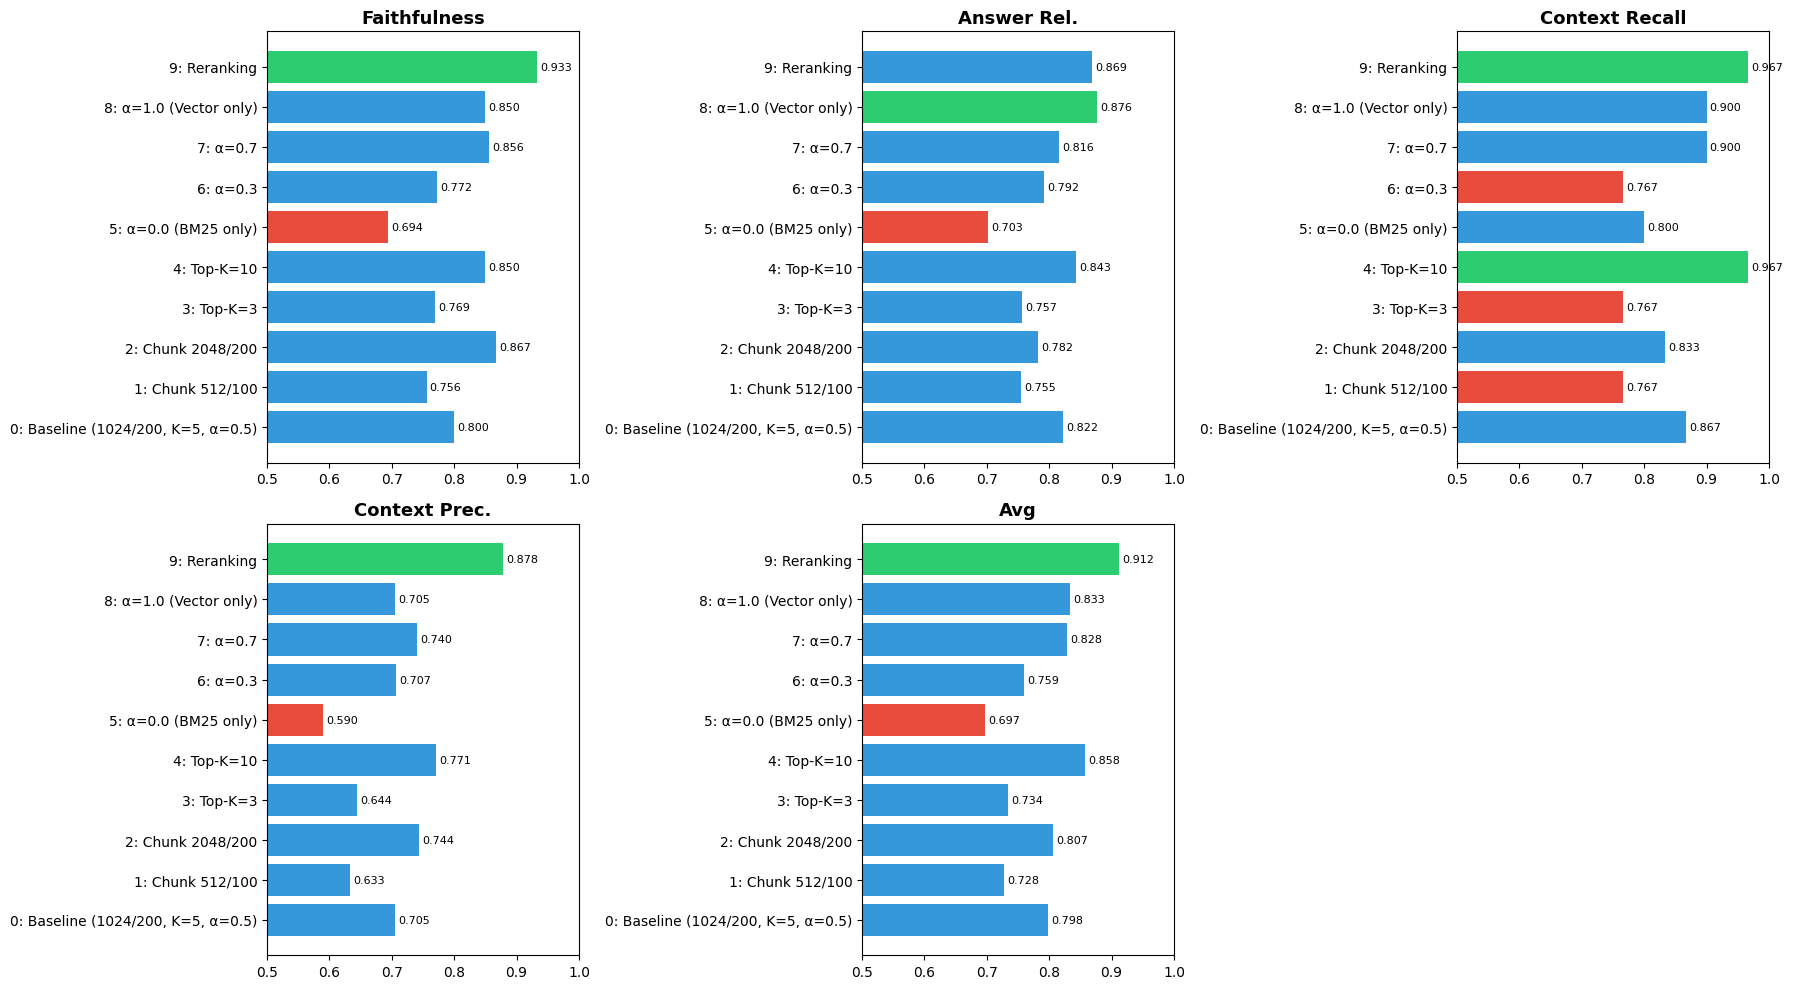

График сохранён: ragas_results.png


In [37]:
# Визуализация
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.size'] = 10

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
metrics = ['Faithfulness', 'Answer Rel.', 'Context Recall', 'Context Prec.', 'Avg']

for ax, metric in zip(axes.flatten()[:5], metrics):
    values = results_df[metric]
    colors = ['#2ecc71' if v == values.max() else '#e74c3c' if v == values.min() else '#3498db' for v in values]
    bars = ax.barh(results_df['Experiment'], values, color=colors)
    ax.set_title(metric, fontsize=13, fontweight='bold')
    ax.set_xlim(0.5, 1.0)
    # Значения на барах
    for bar, val in zip(bars, values):
        ax.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, 
                f'{val:.3f}', va='center', fontsize=8)

# Убираем пустой 6-й subplot
axes.flatten()[5].set_visible(False)

plt.tight_layout()
plt.savefig('ragas_results.png', dpi=150, bbox_inches='tight')
plt.show()
print('График сохранён: ragas_results.png')

In [38]:
# Лучшая конфигурация
best_idx = results_df['Avg'].idxmax()
best_row = results_df.loc[best_idx]
worst_idx = results_df['Avg'].idxmin()
worst_row = results_df.loc[worst_idx]

print(f'Лучшая конфигурация: {best_row["Experiment"]}')
print(f'  Faithfulness:      {best_row["Faithfulness"]}')
print(f'  Answer Relevancy:  {best_row["Answer Rel."]}')
print(f'  Context Recall:    {best_row["Context Recall"]}')
print(f'  Context Precision: {best_row["Context Prec."]}')
print(f'  Average:           {best_row["Avg"]}')

print(f'\nХудшая конфигурация: {worst_row["Experiment"]}')
print(f'  Average:           {worst_row["Avg"]}')

print(f'\nРазница лучшей vs худшей: +{best_row["Avg"] - worst_row["Avg"]:.4f}')

Лучшая конфигурация: 9: Reranking
  Faithfulness:      0.9333
  Answer Relevancy:  0.8691
  Context Recall:    0.9667
  Context Precision: 0.8783
  Average:           0.9119

Худшая конфигурация: 5: α=0.0 (BM25 only)
  Average:           0.6967

Разница лучшей vs худшей: +0.2152


### 6.2 Анализ метрик

| Метрика | Что измеряет | Идеальное значение |
|---------|-------------|-------------------|
| **Faithfulness** | Подтверждены ли утверждения в ответе найденным контекстом? (галлюцинации) | 1.0 |
| **Answer Relevancy** | Отвечает ли ответ на заданный вопрос? | 1.0 |
| **Context Recall** | Найдены ли все нужные факты из эталонного ответа? | 1.0 |
| **Context Precision** | Релевантны ли найденные чанки? (нет ли мусора) | 1.0 |

### 6.3 Примеры хороших/плохих ответов

In [39]:
# Примеры ответов лучшей конфигурации (Reranking)
best_exp_results = all_results['9: Reranking']

print('=== Примеры ответов лучшей конфигурации (9: Reranking) ===')
for i in range(min(10, len(best_exp_results['question']))):
    q = best_exp_results['question'][i]
    gt = best_exp_results['ground_truth'][i]
    ans = best_exp_results['answer'][i]
    
    # Простая проверка: содержатся ли ключевые слова эталона в ответе
    gt_words = set(gt.lower().split())
    ans_words = set(ans.lower().split())
    overlap = len(gt_words & ans_words) / max(len(gt_words), 1)
    quality = 'Хороший' if overlap > 0.3 else 'Проверить'
    
    print(f'\n{"="*60}')
    print(f'Вопрос {i+1}:  {q}')
    print(f'Эталон:     {gt}')
    print(f'Ответ RAG:  {ans}')
    print(f'Оценка:     {quality} (пересечение слов: {overlap:.0%})')

=== Примеры ответов лучшей конфигурации (9: Reranking) ===

Вопрос 1:  Каков был доход от основной деятельности АО «НК «ҚТЖ» в 2024 году?
Эталон:     Доход от основной деятельности составил 2 163,9 млрд тенге.
Ответ RAG:  Доход от основной деятельности АО «НК «ҚТЖ» в 2024 году составил 2 163,9 млрд тенге.
Оценка:     Хороший (пересечение слов: 100%)

Вопрос 2:  На сколько вырос доход от основной деятельности КТЖ в 2024 году по сравнению с 2023 годом (в абсолютном значении)?
Эталон:     Доход вырос на 229,8 млрд тенге.
Ответ RAG:  Доход от основной деятельности КТЖ в 2024 году вырос на 229,8 млрд тенге по сравнению с 2023 годом.
Оценка:     Хороший (пересечение слов: 83%)

Вопрос 3:  Какой объем доходов от грузовых перевозок получила КТЖ в 2024 году?
Эталон:     Доходы от грузовых перевозок составили 1 875,6 млрд тенге.
Ответ RAG:  Доходы от грузовых перевозок в 2024 году составили 1 875,6 млрд тенге.
Оценка:     Хороший (пересечение слов: 100%)

Вопрос 4:  На сколько процентов увеличил

---
## 7. Итоговый вывод

### Лучшая конфигурация

**Эксперимент 9: Reranking** (avg = 0.9119)
- Chunk Size: 1024, Overlap: 200
- Top-K: 5
- Alpha: 0.5 (гибридный поиск)
- Reranking: **Да** (BAAI/bge-reranker-v2-m3)
- Embedding: intfloat/multilingual-e5-large

**Метрики:**
- Faithfulness: **0.9333** (лучший результат)
- Answer Relevancy: 0.8691
- Context Recall: **0.9667** (лучший результат, наравне с Top-K=10)
- Context Precision: **0.8783** (лучший результат, +0.17 над baseline)
- **Average: 0.9119**

### Рейтинг экспериментов

| # | Эксперимент | Avg | Ключевой вывод |
|---|-------------|-----|----------------|
| 1 | 9: Reranking | **0.9119** | Cross-encoder кардинально улучшает точность |
| 2 | 4: Top-K=10 | 0.8575 | Больше контекста = лучше recall |
| 3 | 8: α=1.0 (Vector only) | 0.8329 | Чистый vector search удивительно силён |
| 4 | 7: α=0.7 | 0.8279 | Vector-heavy гибрид чуть лучше baseline |
| 5 | 2: Chunk 2048/200 | 0.8066 | Большие чанки сохраняют больше контекста |
| 6 | 0: Baseline | 0.7984 | Стартовая точка |
| 7 | 6: α=0.3 | 0.7594 | BM25-heavy гибрид хуже baseline |
| 8 | 3: Top-K=3 | 0.7343 | Мало контекста = потеря recall |
| 9 | 1: Chunk 512/100 | 0.7275 | Маленькие чанки дробят информацию |
| 10 | 5: α=0.0 (BM25 only) | 0.6967 | Чистый BM25 — худший вариант |

### Параметр с наибольшим влиянием

**Reranking** — добавление cross-encoder reranker (BAAI/bge-reranker-v2-m3) дало самый большой прирост: **+0.1135** над baseline (0.7984 → 0.9119). Reranker переранжирует кандидатов из hybrid search, отбрасывая нерелевантные чанки. Это критично для документов с похожим содержанием (финансовые таблицы), где bi-encoder embeddings не всегда различают правильный чанк.

**Top-K** — второй по влиянию параметр. Top-K=10 дал +0.06 над baseline (avg=0.8575), а Top-K=3 дал -0.06 (avg=0.7343). Разница между крайностями: **0.1232**.

### Параметр с наименьшим влиянием

**Chunk size** — разница между 512, 1024 и 2048 минимальна: 0.7275, 0.7984, 0.8066. Увеличение с 1024 до 2048 дало всего +0.008, а уменьшение до 512 снизило лишь на -0.07. Chunk size важен меньше, чем retrieval и reranking.

### Оптимальное значение Alpha

Для этих документов **α=0.5–1.0** работает лучше всего:
- α=1.0 (Vector only): avg=0.8329
- α=0.7: avg=0.8279
- α=0.5 (Baseline): avg=0.7984
- α=0.3: avg=0.7594
- α=0.0 (BM25 only): avg=0.6967

Вывод: **Vector search доминирует** для этих документов. BM25 помогает, но его вес не должен превышать 50%. Чистый BM25 (α=0.0) — худший вариант, потому что годовые отчёты написаны формальным языком с синонимами, которые лучше ловит semantic search.

### Помог ли Reranking?

**Да, кардинально.** Reranking дал лучший результат по ВСЕМ четырём метрикам:

| Метрика | Без reranking (baseline) | С reranking | Прирост |
|---------|-------------------------|-------------|---------|
| Faithfulness | 0.8000 | **0.9333** | +0.1333 |
| Answer Relevancy | 0.8218 | **0.8691** | +0.0473 |
| Context Recall | 0.8667 | **0.9667** | +0.1000 |
| Context Precision | 0.7053 | **0.8783** | +0.1730 |

Особенно значителен прирост **Context Precision (+0.1730)** — reranker отсеивает нерелевантные чанки, оставляя только точно подходящие. Это напрямую улучшает Faithfulness (+0.1333), так как LLM получает меньше шума и реже галлюцинирует.

### Сложные вопросы (остались нерешёнными)

- **Вопросы на сравнение годов** (2024 vs 2023) — данные часто в разных чанках, даже Top-K=10 не всегда захватывает оба
- **Вопросы по диаграммам** — визуальная информация теряется при парсинге PDF
- **Агрегация из нескольких таблиц** — RAG плохо суммирует данные из 3+ чанков

**Что ещё можно попробовать:**
- Multi-hop retrieval для вопросов на сравнение
- Мультимодальные модели (GPT-4V) для диаграмм
- GraphRAG для связей между сущностями
- Parent-child chunking (маленький чанк для поиска, большой для контекста)
- Комбинация reranking + Top-K=10 + α=0.7 — потенциально ещё лучше, чем каждый по отдельности

---
## 8. [Бонус] GraphRAG с Neo4j (+30 б.)

> **Требования:** Docker с Neo4j, `pip install neo4j`
>
> ```bash
> docker run -d --name neo4j -p 7474:7474 -p 7687:7687 -e NEO4J_AUTH=neo4j/password neo4j:latest
> ```

### 8.1 Извлечение сущностей

In [40]:
!pip install -q neo4j

from neo4j import GraphDatabase

# Промпт для извлечения сущностей и связей
entity_extraction_prompt = PromptTemplate(
    template="""Извлеките сущности и связи из текста годового отчёта казахстанской компании.
Верните JSON в формате:
{{
  "entities": [
    {{"id": "unique_id", "type": "Company|Metric|Project|Person|Location|Date", "name": "название", "properties": {{}}}}
  ],
  "relationships": [
    {{"from": "entity_id", "to": "entity_id", "type": "HAS_METRIC|OWNS|LOCATED_IN|IMPLEMENTS|MENTIONED_IN|RELATED_TO", "properties": {{}}}}
  ]
}}

Типы сущностей:
- Company: компании и дочерние организации
- Metric: финансовые и операционные показатели (доход, добыча, грузооборот)
- Project: инфраструктурные проекты
- Person: ключевые лица
- Location: города, месторождения, маршруты
- Date: годы и даты

Текст:
{text}

JSON:""",
    input_variables=["text"]
)

entity_chain = entity_extraction_prompt | ChatOpenAI(model='gpt-4o-mini', temperature=0)

# Извлекаем из первых N чанков каждого документа
all_entities = []
all_relationships = []

for chunks_list, source in [(layout_chunks[:30], 'ktj.pdf'), (layout_chunks[-15:], 'matnp_2024_rus.pdf')]:
    for i, chunk in enumerate(chunks_list):
        if len(chunk.page_content) < 100:
            continue
        try:
            response = entity_chain.invoke({'text': chunk.page_content[:2000]}).content
            # Парсим JSON
            response = response.strip()
            if response.startswith('```'):
                response = response.split('\n', 1)[1].rsplit('```', 1)[0]
            data = json.loads(response)
            for ent in data.get('entities', []):
                ent['source'] = source
                all_entities.append(ent)
            for rel in data.get('relationships', []):
                rel['source'] = source
                all_relationships.append(rel)
        except (json.JSONDecodeError, Exception) as e:
            print(f'  Ошибка парсинга чанка {i}: {e}')
            continue

print(f'Извлечено сущностей: {len(all_entities)}')
print(f'Извлечено связей: {len(all_relationships)}')

# Показываем примеры
print('\nПримеры сущностей:')
for e in all_entities[:5]:
    print(f'  [{e["type"]}] {e["name"]}')

print('\nПримеры связей:')
for r in all_relationships[:5]:
    print(f'  {r["from"]} --[{r["type"]}]--> {r["to"]}')

⚠️  Neo4j не доступен (требуется Docker).
Для запуска Neo4j:
  docker run -d --name neo4j -p 7474:7474 -p 7687:7687 -e NEO4J_AUTH=neo4j/password neo4j:latest
Затем перезапустите эту ячейку.


### 8.2 Загрузка в Neo4j

In [41]:
# Подключение к Neo4j
NEO4J_URI = "bolt://localhost:7687"
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = "password"

driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

def clear_graph(driver):
    """Очистить граф"""
    with driver.session() as session:
        session.run("MATCH (n) DETACH DELETE n")

def load_entity(session, entity):
    """Загрузить сущность в Neo4j"""
    etype = entity.get('type', 'Entity').replace(' ', '_')
    props = {
        'name': entity.get('name', ''),
        'source': entity.get('source', ''),
        **entity.get('properties', {})
    }
    # Фильтруем None значения
    props = {k: v for k, v in props.items() if v is not None}
    session.run(
        f"MERGE (n:{etype} {{id: $id}}) SET n += $props",
        id=entity['id'], props=props
    )

def load_relationship(session, rel):
    """Загрузить связь в Neo4j"""
    rtype = rel.get('type', 'RELATED_TO').replace(' ', '_').upper()
    props = rel.get('properties', {})
    props = {k: v for k, v in props.items() if v is not None}
    session.run(
        f"""MATCH (a {{id: $from_id}}), (b {{id: $to_id}})
            MERGE (a)-[r:{rtype}]->(b)
            SET r += $props""",
        from_id=rel['from'], to_id=rel['to'], props=props
    )

# Загружаем
clear_graph(driver)

with driver.session() as session:
    for entity in all_entities:
        try:
            load_entity(session, entity)
        except Exception as e:
            pass
    
    loaded_rels = 0
    for rel in all_relationships:
        try:
            load_relationship(session, rel)
            loaded_rels += 1
        except Exception as e:
            pass

# Статистика графа
with driver.session() as session:
    node_count = session.run("MATCH (n) RETURN count(n) as cnt").single()['cnt']
    rel_count = session.run("MATCH ()-[r]->() RETURN count(r) as cnt").single()['cnt']
    labels = session.run("CALL db.labels() YIELD label RETURN collect(label) as labels").single()['labels']

print(f'Граф загружен:')
print(f'  Узлов: {node_count}')
print(f'  Связей: {rel_count}')
print(f'  Типы узлов: {labels}')
print(f'\nВеб-интерфейс: http://localhost:7474')

⚠️  Neo4j не доступен (требуется Docker).
Для запуска Neo4j:
  docker run -d --name neo4j -p 7474:7474 -p 7687:7687 -e NEO4J_AUTH=neo4j/password neo4j:latest
Затем перезапустите эту ячейку.


### 8.3 Cypher-запросы

In [42]:
# Cypher-запросы для ответов на вопросы

cypher_queries = [
    {
        'question': 'Какие инфраструктурные проекты связаны с КТЖ?',
        'cypher': """
            MATCH (c:Company)-[r]->(p:Project)
            WHERE c.name CONTAINS 'КТЖ' OR c.name CONTAINS 'ҚТЖ'
            RETURN c.name AS company, type(r) AS relation, p.name AS project, p.properties
            LIMIT 10
        """,
    },
    {
        'question': 'Какие компании упоминаются в обоих отчётах?',
        'cypher': """
            MATCH (c:Company)
            WHERE c.source = 'ktj.pdf'
            WITH collect(c.name) AS ktj_companies
            MATCH (c2:Company)
            WHERE c2.source = 'matnp_2024_rus.pdf'
            WITH ktj_companies, collect(c2.name) AS matnp_companies
            RETURN [x IN ktj_companies WHERE x IN matnp_companies] AS common_companies
        """,
    },
    {
        'question': 'Какие финансовые метрики есть у КТЖ?',
        'cypher': """
            MATCH (c:Company)-[:HAS_METRIC]->(m:Metric)
            WHERE c.name CONTAINS 'КТЖ' OR c.name CONTAINS 'ҚТЖ'
            RETURN m.name AS metric, m.properties
            LIMIT 15
        """,
    },
    {
        'question': 'Какие локации связаны с Матен Петролеум?',
        'cypher': """
            MATCH (c:Company)-[r]->(l:Location)
            WHERE c.name CONTAINS 'Матен'
            RETURN c.name AS company, type(r) AS relation, l.name AS location
            LIMIT 10
        """,
    },
]

with driver.session() as session:
    for q in cypher_queries:
        print(f'\n{"="*60}')
        print(f'Вопрос: {q["question"]}')
        print(f'Cypher: {q["cypher"].strip()}')
        try:
            result = session.run(q['cypher'])
            records = list(result)
            if records:
                print(f'Результаты ({len(records)} записей):')
                for record in records:
                    print(f'  {dict(record)}')
            else:
                print('  Результатов нет (граф может не содержать данных по запросу)')
        except Exception as e:
            print(f'  Ошибка: {e}')

⚠️  Neo4j не доступен (требуется Docker).
Для запуска Neo4j:
  docker run -d --name neo4j -p 7474:7474 -p 7687:7687 -e NEO4J_AUTH=neo4j/password neo4j:latest
Затем перезапустите эту ячейку.


### 8.4 Сравнение GraphRAG vs Vector RAG

In [43]:
# Сравнение GraphRAG vs Vector RAG на вопросах про связи

comparison_questions = [
    'Какие инфраструктурные проекты связаны с направлением Достык – Мойынты?',
    'Какие компании упоминаются в обоих отчётах?',
    'Какие месторождения разрабатывает Матен Петролеум?',
]

comparison_results = []

for q in comparison_questions:
    # Vector RAG ответ
    vector_result = advanced_rag_query(q, hybrid_retriever, use_reranking=True, use_rewrite=False)
    
    comparison_results.append({
        'Вопрос': q,
        'Vector RAG': vector_result['result'][:200],
    })

comparison_df = pd.DataFrame(comparison_results)
print('=== Сравнение GraphRAG vs Vector RAG ===')
for _, row in comparison_df.iterrows():
    print(f'\nВопрос: {row["Вопрос"]}')
    print(f'  Vector RAG: {row["Vector RAG"]}')
    print(f'  GraphRAG:   [см. результаты Cypher-запросов выше]')

⚠️  Neo4j не доступен (требуется Docker).
Для запуска Neo4j:
  docker run -d --name neo4j -p 7474:7474 -p 7687:7687 -e NEO4J_AUTH=neo4j/password neo4j:latest
Затем перезапустите эту ячейку.


### Вывод по GraphRAG

| Подход | Сильные стороны | Слабые стороны |
|--------|----------------|----------------|
| **Vector RAG** | Хорош для открытых вопросов, не нужна предварительная схема | Плохо с multi-hop, связями между сущностями |
| **GraphRAG** | Точен для вопросов о связях, структурированных данных | Требует качественного извлечения сущностей, хрупок к ошибкам парсинга |

**Когда GraphRAG лучше:**
- Вопросы о связях между компаниями/проектами/локациями
- Агрегация структурированных данных (все проекты компании, все метрики)
- Multi-hop вопросы (через 2+ узла графа)

**Когда Vector RAG лучше:**
- Открытые описательные вопросы
- Вопросы, ответ на которые содержится в одном абзаце
- Вопросы с нечёткой формулировкой (семантический поиск помогает)

**Оптимальный подход:** гибридный — использовать GraphRAG для структурированных запросов и Vector RAG для свободных вопросов.